In [1]:
import meep as mp
import math
import cmath
import numpy as np
from matplotlib import pyplot as plt

Using MPI version 4.0, 1 processes


In [2]:
resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # length of padding between grating and PML
gp = 10.0  # grating period
gh = 0.5  # grating height
gdc = 0.5  # grating duty cycle

sx = dpml + dsub + gh + dpad + dpml
sy = gp

cell_size = mp.Vector3(sx, sy, 0)
pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

In [3]:
ng = 1.5
glass = mp.Medium(index=ng)

wvl = 0.5  # center wavelength
fcen = 1 / wvl  # center frequency
df = 0.05 * fcen  # frequency width

# rotation angle of incident planewave; counter clockwise (CCW) about Z axis, 0 degrees along +X axis
theta_in = math.radians(10.7)

# k (in source medium) with correct length (plane of incidence: XY)
k = mp.Vector3(fcen * ng).rotate(mp.Vector3(z=1), theta_in)

symmetries = []
eig_parity = mp.ODD_Z
if theta_in == 0:
    k = mp.Vector3(0, 0, 0)
    symmetries = [mp.Mirror(mp.Y)]
    eig_parity += mp.EVEN_Y


def pw_amp(k, x0):
    def _pw_amp(x):
        return cmath.exp(1j * 2 * math.pi * k.dot(x + x0))

    return _pw_amp


src_pt = mp.Vector3(-0.5 * sx + dpml + 0.3 * dsub, 0, 0)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(0, sy, 0),
        amp_func=pw_amp(k, src_pt),
    )
]

In [4]:
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    k_point=k,
    default_material=glass,
    sources=sources,
    symmetries=symmetries,
)

refl_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub, 0, 0)
refl_flux = sim.add_flux(
    fcen, 0, 1, mp.FluxRegion(center=refl_pt, size=mp.Vector3(0, sy, 0))
)

In [5]:
sim.run(until_after_sources=100)

input_flux = mp.get_fluxes(refl_flux)
input_flux_data = sim.get_flux_data(refl_flux)

-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 2D dimensions.
Computational cell is 8.5 x 10 x 0 with resolution 50
time for set_epsilon = 0.238215 s
-----------
Meep: using complex fields.
Meep progress: 18.080000000000002/200.0 = 9.0% done in 4.0s, 40.3s to go
on time step 1808 (time=18.08), 0.00221339 s/step
Meep progress: 36.2/200.0 = 18.1% done in 8.0s, 36.2s to go
on time step 3620 (time=36.2), 0.00220775 s/step
Meep progress: 53.4/200.0 = 26.7% done in 12.0s, 33.0s to go
on time step 5340 (time=53.4), 0.00232595 s/step
Meep progress: 71.64/200.0 = 35.8% done in 16.0s, 28.7s to go
on time step 7164 (time=71.64), 0.00219375 s/step
Meep progress: 89.19/200.0 = 44.6% done in 20.0s, 24.9s to go
on time step 8919 (time=89.19), 0.00227957 s/step
Meep progress: 106.5/200.0 = 53.2% done in 24.0s, 21.1s to go
on time step 10651 (time=106.51), 0.00231053 s/step
Meep progress: 124.02/200.0 = 62.0% done in 28.0s, 17.2s to go
on time step 12404 (

In [6]:
sim.reset_meep()

geometry = [
    mp.Block(
        material=glass,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub), 0, 0),
    ),
    mp.Block(
        material=glass,
        size=mp.Vector3(gh, gdc * gp, mp.inf),
        center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh, 0, 0),
    ),
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k,
    sources=sources,
    symmetries=symmetries,
)

refl_flux = sim.add_flux(
    fcen, 0, 1, mp.FluxRegion(center=refl_pt, size=mp.Vector3(0, sy, 0))
)
sim.load_minus_flux_data(refl_flux, input_flux_data)

tran_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad, 0, 0)
tran_flux = sim.add_flux(
    fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0, sy, 0))
)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00153494 s
Working in 2D dimensions.
Computational cell is 8.5 x 10 x 0 with resolution 50
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.377495 s
-----------
Meep: using complex fields.


In [7]:
sim.run(until_after_sources=200)

Meep progress: 18.42/300.0 = 6.1% done in 4.0s, 61.2s to go
on time step 1842 (time=18.42), 0.00217211 s/step
Meep progress: 36.92/300.0 = 12.3% done in 8.0s, 57.0s to go
on time step 3692 (time=36.92), 0.00216277 s/step
Meep progress: 55.300000000000004/300.0 = 18.4% done in 12.0s, 53.1s to go
on time step 5531 (time=55.31), 0.00217589 s/step
Meep progress: 73.03/300.0 = 24.3% done in 16.0s, 49.7s to go
on time step 7304 (time=73.04), 0.00225647 s/step
Meep progress: 90.10000000000001/300.0 = 30.0% done in 20.0s, 46.6s to go
on time step 9011 (time=90.11), 0.00234519 s/step
Meep progress: 107.62/300.0 = 35.9% done in 24.0s, 42.9s to go
on time step 10764 (time=107.64), 0.00228223 s/step
Meep progress: 126.17/300.0 = 42.1% done in 28.0s, 38.6s to go
on time step 12620 (time=126.2), 0.00215656 s/step
Meep progress: 144.74/300.0 = 48.2% done in 32.0s, 34.3s to go
on time step 14478 (time=144.78), 0.0021534 s/step
Meep progress: 163.43/300.0 = 54.5% done in 36.0s, 30.1s to go
on time step

In [8]:
# Calculate the number of reflected orders
nm_r = np.floor((fcen * ng - k.y) * gp) - np.ceil(
    (-fcen * ng - k.y) * gp
)  # number of reflected orders
if theta_in == 0:
    nm_r = nm_r / 2  # since eig_parity removes degeneracy in y-direction
nm_r = int(nm_r)

# Extract the coefficients for the reflected orders
res = sim.get_eigenmode_coefficients(
    refl_flux, range(1, nm_r + 1), eig_parity=eig_parity
)
r_coeffs = res.alpha

# Calculate the number of transmitted orders
nm_t = np.floor((fcen - k.y) * gp) - np.ceil(
    (-fcen - k.y) * gp
)  # number of transmitted orders
if theta_in == 0:
    nm_t = nm_t / 2  # since eig_parity removes degeneracy in y-direction
nm_t = int(nm_t)

# Extract the coefficients for the transmitted orders
res = sim.get_eigenmode_coefficients(
    tran_flux, range(1, nm_t + 1), eig_parity=eig_parity
)
t_coeffs = res.alpha

MPB solved for frequency_1(3,0.557,0) = 2.00021 after 221 iters
MPB solved for frequency_1(2.99969,0.557,0) = 2 after 1 iters
Dominant planewave for band 1: (2.999692,-0.043000,0.000000)
MPB solved for frequency_2(3,0.557,0) = 2.00036 after 126 iters
MPB solved for frequency_2(2.99946,0.557,0) = 2 after 1 iters
Dominant planewave for band 2: (2.999458,0.057000,0.000000)
MPB solved for frequency_3(3,0.557,0) = 2.00227 after 158 iters
MPB solved for frequency_3(2.99659,0.557,0) = 2 after 1 iters
MPB solved for frequency_3(2.99659,0.557,0) = 2 after 1 iters
Dominant planewave for band 3: (2.996590,-0.143000,0.000000)
MPB solved for frequency_4(3,0.557,0) = 2.00274 after 101 iters
MPB solved for frequency_4(2.99589,0.557,0) = 2 after 1 iters
MPB solved for frequency_4(2.99589,0.557,0) = 2 after 1 iters
Dominant planewave for band 4: (2.995889,0.157000,0.000000)
MPB solved for frequency_5(3,0.557,0) = 2.00655 after 134 iters
MPB solved for frequency_5(2.99014,0.557,0) = 2 after 1 iters
MPB 

/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


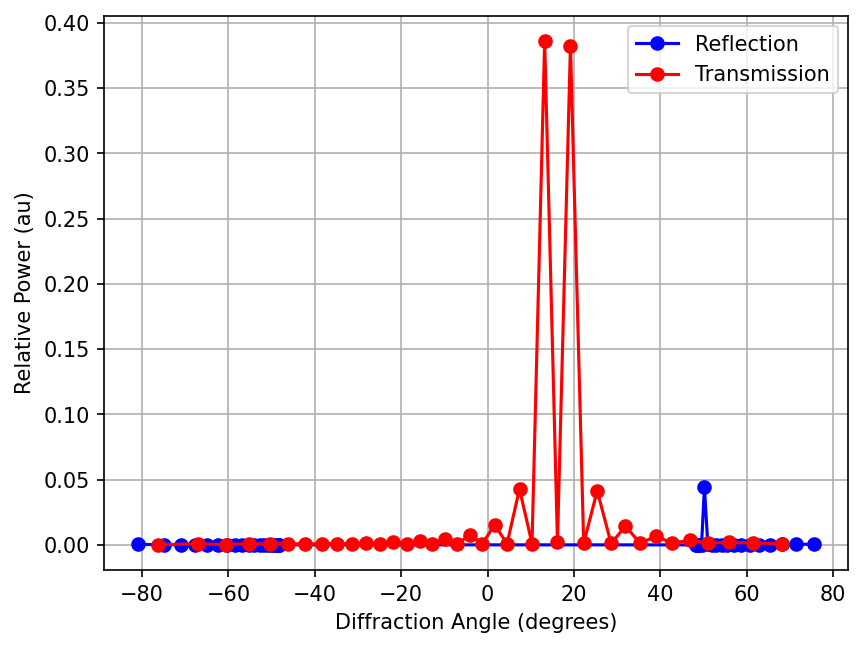

In [9]:
r_angle = np.squeeze(
    [
        math.degrees(np.sign(r_kdom.y) * math.acos(r_kdom.x / (ng * fcen)))
        for r_kdom in res.kdom
    ]
)
Rmode = abs(r_coeffs[:, 0, 1]) ** 2 / input_flux[0]
idx_r = np.argsort(r_angle)

t_angle = np.squeeze(
    [
        math.degrees(np.sign(t_kdom.y) * math.acos(t_kdom.x / fcen))
        for t_kdom in res.kdom
    ]
)
Tmode = abs(t_coeffs[:, 0, 0]) ** 2 / input_flux[0]
idx_t = np.argsort(t_angle)

plt.figure(dpi=150)
plt.plot(r_angle[idx_r], Rmode[idx_r], "o-", color="blue", label="Reflection")
plt.plot(t_angle[idx_t], Tmode[idx_t], "o-", color="red", label="Transmission")
plt.grid(True)
plt.xlabel("Diffraction Angle (degrees)")
plt.ylabel("Relative Power (au)")
plt.legend()
plt.show()

In [10]:
print(
    "mode-coeff:, {:.6f}, {:.6f}, {:.6f}".format(
        np.sum(Rmode), np.sum(Tmode), np.sum(Rmode) + np.sum(Tmode)
    )
)
r_flux = mp.get_fluxes(refl_flux)
t_flux = mp.get_fluxes(tran_flux)
Rflux = -r_flux[0] / input_flux[0]
Tflux = t_flux[0] / input_flux[0]
print("poynting-flux:, {:.6f}, {:.6f}, {:.6f}".format(Rflux, Tflux, Rflux + Tflux))

mode-coeff:, 0.061050, 0.937863, 0.998913
poynting-flux:, 0.061105, 0.938341, 0.999447
